# Purchase model using e-commerce data

### Import packages

In [1]:
# data processing
import numpy as np
import pandas as pd
from datetime import date

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Set-up

For this expercise, we will utilize two files (listed below) from the 'Brazilian E-Commerce Public Dataset' originally posted on [Kaggle]( https://www.kaggle.com/olistbr/brazilian-ecommerce).

In [2]:
# full path of the orders dataset
orders_file = '../data/olist_orders_dataset.csv'

# full path of the customer dataset
cust_file = '../data/olist_customers_dataset.csv'

##look at files to determine other attributes...
# cust_file_test = pd.read_csv('../data/olist_customers_dataset.csv')
# cust_file_test.head()

# orders_file_test = pd.read_csv('../data/olist_orders_dataset.csv')
# orders_file_test.head()

### Read data

In [10]:
def read_olist_data(file1, file2, use_cols, cutoff_dt, verbose):
    
    # read the orders data
    orders = pd.read_csv(file1)

    if verbose:
        print (f'{len(orders):,} read from the orders file.')

    # date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])


    # let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date
    orders['order_estimated_delivery_date'] = orders['order_estimated_delivery_date'].dt.date

    # extract month from the order date
    orders['order_dow'] = orders['order_purchase_timestamp'].dt.day_name()

    # read the file that contains the unique customer identifier
    # also, let's keep only the following two columns: customer_id, customer_unique_id
    cust = pd.read_csv(file2, usecols=['customer_id', 'customer_unique_id'])
    
    if verbose:
        print (f'{len(cust):,} read from the customer file.')

    # merge orders and cust dataframes
    orders_out = pd.merge(orders, cust, on='customer_id', how='inner')
    
    # discard (incomplete) data after cutoff_dt
    # we do this here by using a boolean (True/False) mask
    mask = orders_out['order_purchase_date'] <= cutoff_dt

    orders_out = orders_out[mask]
    
    # sort the output dataset by order date for each customer
    orders_out = orders_out[use_cols].sort_values(['customer_unique_id', 'order_purchase_timestamp'])

    if verbose:
        print (f'{len(orders_out):,} records in the output  file.')
    
    return orders_out

In [11]:
# we will keep only these columns for this exercise
use_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_dow']

# we will discard (incomplete) data after 8/22/18 (see 06_pandas_wrangle.ipynb for the rationale)
cutoff_date = date(2018, 8, 22)

orders = read_olist_data(orders_file, cust_file, use_cols, cutoff_date, 1)

99,441 read from the orders file.
99,441 read from the customer file.
98,906 records in the output  file.


This is our combined raw dataset from which we will create attributes and label for each customer.

## Binary Classification Model: Data Preparation

Let's build a model to predict whether a customer will make a purchase within the next month.

We will use *July 2018*, which is the most recent complete month, as the prediction window. In other words, we will use all available data prior to July 2018 to predict which customers will make a purchase in July 2018.

In [12]:
snapshot_date = date(2017,12,31) #for assign3 change this to (2017, 12, 31) #latest observation window date

### MODIFY DF FOR ADDT'L ATTRIBUTES AC

In [13]:
#add 'order_status' to use_cols2

use_cols2 = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_estimated_delivery_date','order_status']

orders2 = read_olist_data(orders_file, cust_file, use_cols2, cutoff_date, 1)

99,441 read from the orders file.
99,441 read from the customer file.
98,906 records in the output  file.


In [16]:
mask = orders2['order_purchase_timestamp'].dt.date <= snapshot_date

df_raw2 = orders2[mask]

#print(len(df_raw2), df_raw2.order_purchase_timestamp.min(),df_raw2.order_purchase_timestamp.max())

### Attribute #1A: Most Recent Week ordered

In [17]:
df_raw1a = df_raw2

In [27]:
df_raw1a['week'] = pd.DatetimeIndex(df_raw1a['order_purchase_timestamp']).weekofyear

<ipython-input-27-9abd32f81591>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_raw1a['week'] = pd.DatetimeIndex(df_raw1a['order_purchase_timestamp']).weekofyear
<ipython-input-27-9abd32f81591>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw1a['week'] = pd.DatetimeIndex(df_raw1a['order_purchase_timestamp']).weekofyear


In [40]:
week_num = df_raw1a[['customer_unique_id', 'order_id','week']]

week_num = week_num.groupby('customer_unique_id')['week'].min().reset_index()

In [41]:
week_num.head()

,customer_unique_id,week
0,0000f46a3911fa3c0805444483337064,10
1,0000f6ccb0745a6a4b88665a16c9f078,41
2,0004aac84e0df4da2b147fca70cf8255,46
3,0005e1862207bf6ccc02e4228effd9a0,9
4,0006fdc98a402fceb4eb0ee528f6a8d4,29


In [42]:
week_num.groupby('week').size().head()

week
1     31
2     77
3    191
4    348
5    459
dtype: int64

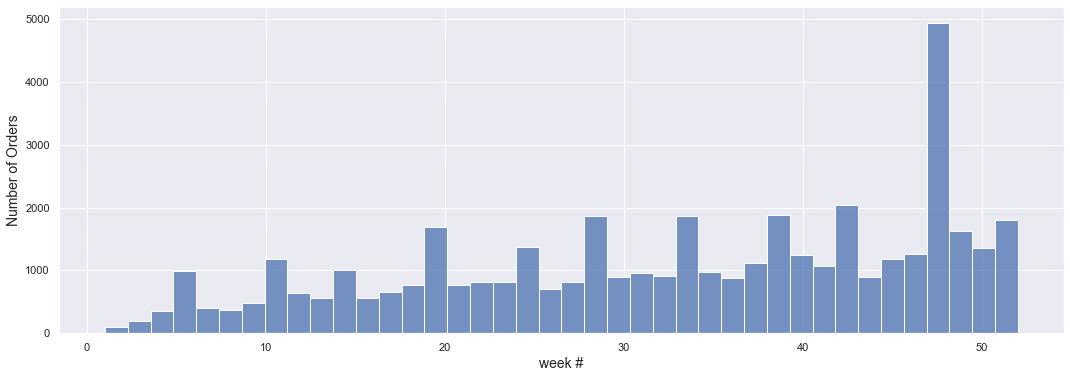

In [43]:
###add rolling average line plot
###keep only past year
### take rolling avg (3 weeks, and get % of rolling average) [every 3rd week is above avg by X percent]

sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(18, 6)

# histogram
sns.histplot(week_num['week'], kde=False)

# assign axis labels
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('week #', fontsize=14);

In [44]:
len(week_num)

#week_nums.head()

44034

### Attribute 2A: ESTIMATED DELIVERY TIME (Most recent)

In [45]:
# there are empty delivery dates for customers that didn't order. I think it would be important not to remove them...
# probably have to use estimated delivery date...make sense because that MAY be what caused them to cancel.

# 'order_estimated_delivery_date' Shows the ESTIMATED order delivery date to the customer.

df_raw2['order_estimated_delivery_date'] = pd.to_datetime(df_raw2['order_estimated_delivery_date'])

delta2 = df_raw2['order_estimated_delivery_date'].dt.date - df_raw2['order_purchase_timestamp'].dt.date

est_delivery = df_raw2

est_delivery.head()

<ipython-input-45-d3fb4a361ae4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw2['order_estimated_delivery_date'] = pd.to_datetime(df_raw2['order_estimated_delivery_date'])


,customer_unique_id,order_id,order_purchase_timestamp,order_estimated_delivery_date,order_status,week
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,2017-04-07,delivered,10
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2017-11-13,delivered,41
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,2017-12-05,delivered,46
71235,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,2017-04-06,delivered,9
26203,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,2017-07-18 09:23:10,2017-08-15,delivered,29


In [47]:
# grab the number of days (as an integer) from the calculated deltas

est_delivery['est_delivery_days'] = delta2.dt.days

est_delivery.est_delivery_days = est_delivery.est_delivery_days.astype(int)

est_delivery.head()

<ipython-input-47-f8c7d643da91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  est_delivery['est_delivery_days'] = delta2.dt.days
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,customer_unique_id,order_id,order_purchase_timestamp,order_estimated_delivery_date,order_status,week,est_delivery_days
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,2017-04-07,delivered,10,28
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,2017-11-13,delivered,41,32
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,2017-12-05,delivered,46,21
71235,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,2017-03-04 23:32:12,2017-04-06,delivered,9,33
26203,0006fdc98a402fceb4eb0ee528f6a8d4,6681163e3dab91c549952b2845b20281,2017-07-18 09:23:10,2017-08-15,delivered,29,28


In [50]:
# grab the mean est. delivery days each customer

est_delivery = est_delivery.groupby('customer_unique_id')['est_delivery_days'].mean().reset_index()

len(est_delivery)

44034

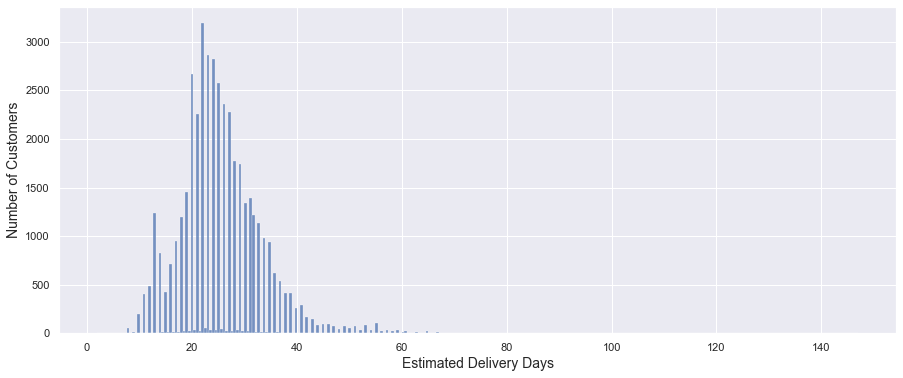

In [51]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.histplot(est_delivery['est_delivery_days'], kde=False)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Estimated Delivery Days', fontsize=14);

### Attribute #3A: Order Status

In [52]:
# dummies for order_status (approved, canceled, etc)

order_status = pd.get_dummies(df_raw2, columns=['order_status'])

In [53]:
# grab all binary columns that we just created
dummies2 = [x for x in order_status.columns if 'order_status' in x]

# aggreagte data to the customer-level, so that we have one record per customer
order_status = order_status.groupby('customer_unique_id')[dummies2].sum().reset_index()

order_status.head()

,customer_unique_id,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,0000f46a3911fa3c0805444483337064,0,0,0,1,0,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,1,0,0,0,0
2,0004aac84e0df4da2b147fca70cf8255,0,0,0,1,0,0,0,0
3,0005e1862207bf6ccc02e4228effd9a0,0,0,0,1,0,0,0,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0,0,0,1,0,0,0,0


In [55]:
order_status.shape, est_delivery.shape, week_num.shape

((44034, 9), (44034, 2), (44034, 2))

### Combine all attributes into a single dataframe (AC Attributes)

In [56]:
df2 = pd.merge(week_num, est_delivery, on='customer_unique_id').merge(order_status, on='customer_unique_id')

### Assign labels (aka the target variable or the dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make *at least one purchase* in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [58]:
# select orders that were placed between jan 1 2018 & july 31 2018 (cutoff_date)

mask = (orders['order_purchase_timestamp'].dt.month >= 1) & \
        (orders['order_purchase_timestamp'].dt.month <= 7) & \
        (orders['order_purchase_timestamp'].dt.year == 2018)

target_events_raw = orders[mask] #masks ALL orders

len(target_events_raw)

47479

In [59]:
# confirm the min and max dates are between Jan and July 2018

print({target_events_raw['order_purchase_timestamp'].min()},{target_events_raw['order_purchase_timestamp'].max()})

{Timestamp('2018-01-01 02:48:41')} {Timestamp('2018-07-31 23:54:20')}


**Step 2:** Summarize data to get one record per customer.

In [60]:
# count the number of orders (we will convert this into a binary flag later) 

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'purch'})

target_events.shape

(46412, 2)

In [61]:
target_events.groupby('purch').size()

#week_nums.groupby('week').size().head()

purch
1    45417
2      936
3       50
4        6
5        2
6        1
dtype: int64

In [62]:
print(f'Number of customers who made at least one purchase during the prediction window: {len(target_events):,}')

Number of customers who made at least one purchase during the prediction window: 46,412


**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [76]:
# merge `target_events` with the dataframe that contains customer attributes

df = pd.merge(df2, target_events, how='left', on='customer_unique_id')

df.head()


,customer_unique_id,week,est_delivery_days,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,purch
0,0000f46a3911fa3c0805444483337064,10,28.0,0,0,0,1,0,0,0,0,NaN
1,0000f6ccb0745a6a4b88665a16c9f078,41,32.0,0,0,0,1,0,0,0,0,NaN
2,0004aac84e0df4da2b147fca70cf8255,46,21.0,0,0,0,1,0,0,0,0,NaN
3,0005e1862207bf6ccc02e4228effd9a0,9,33.0,0,0,0,1,0,0,0,0,NaN
4,0006fdc98a402fceb4eb0ee528f6a8d4,29,28.0,0,0,0,1,0,0,0,0,NaN


We need to convert this variable into a binary flag.

**Step 4:** Set the target variable to 1 if at least one purchase was made, 0 otherwise.

In [79]:
# create the binary target flag 
# keep in mind these customers (622) mostly made purchases in the predicted window, results in 622

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

In [80]:
df.purch.value_counts()

0    43407
1      627
Name: purch, dtype: int64

In [81]:
print(f'''# of customers that made purchase at least 1 purchase in the predicted window is 
{df.purch.value_counts()[1]:,} for the snapshot window''')

# of customers that made purchase at least 1 purchase in the predicted window is 
627 for the snapshot window


In [82]:
# % distribution of the target flag

df.purch.value_counts() / len(df)

0    0.985761
1    0.014239
Name: purch, dtype: float64

There are two issues here: (1) the target event is extremely rare, and (2) the number of target events is also extremely small. There are several ways to circumvent these issues, but for now we will proceed with this dataset. 

In [83]:
# check the correlations

df.corr()['purch']

week                        0.006749
est_delivery_days          -0.007937
order_status_approved      -0.000810
order_status_canceled      -0.009803
order_status_created        0.018967
order_status_delivered      0.051911
order_status_invoiced      -0.002171
order_status_processing     0.001437
order_status_shipped        0.002293
order_status_unavailable    0.000730
purch                       1.000000
Name: purch, dtype: float64

### Model building

In [85]:
df.columns

Index(['customer_unique_id', 'week', 'est_delivery_days',
       'order_status_approved', 'order_status_canceled',
       'order_status_created', 'order_status_delivered',
       'order_status_invoiced', 'order_status_processing',
       'order_status_shipped', 'order_status_unavailable', 'purch'],
      dtype='object')

In [86]:
# set-up

preds = df.columns[1:-1]

X = df[preds]
y = df['purch']

Tri-fold partitioning is recommended as long as there's sufficient sample size avaiable. In this example, since the number of target events is very small, we will perform a two-fold paritioning of the modeling sample.

### Two-fold partition

In [87]:
# split the dataframe into train(50%) and test(50%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1111)

len(X_train), len(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22017, 10), (22017, 10), (22017,), (22017,))

In [88]:
# target distribution in the training sample

y_train.value_counts()

0    21689
1      328
Name: purch, dtype: int64

In [89]:
# target distribution in the test sample

y_test.value_counts()

0    21718
1      299
Name: purch, dtype: int64

In [158]:
from sklearn.linear_model import LogisticRegression

# define the model object ('liblinear' is recommended for small datasets), initialize classifier
clf_log = LogisticRegression(solver='liblinear', weightclass = 'balanced', random_state=1111)

# train (fit) the model using the training sample
clf_log.fit(X_train, y_train)

# make predictions on the test sample, contains 0's or 1's.
y_preds_log = clf_log.predict(X_test)

TypeError: __init__() got an unexpected keyword argument 'weightclass'

In [92]:
y_preds_log[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Decision tree classification

In [94]:
from sklearn.tree import DecisionTreeClassifier

# define the model object ('liblinear' is recommended for small datasets), initialize classifier
clf_tree = DecisionTreeClassifier(max_depth = 5, random_state=1111)

# train (fit) the model using the training sample

clf_tree.fit(X_train, y_train)

# make predictions on the test sample, contains 0's or 1's.
y_preds_tree = clf_tree.predict(X_test)

In [95]:
y_preds_tree[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### Area under the ROC curve (AUC) - LOG

In [98]:
# calculate the probabilities on the test sample
y_scores_log = clf_log.predict_proba(X_test)[:, 1]

# calcualte AUC
log_AUC = roc_auc_score(y_test, y_scores_log)
log_AUC

0.5715634827821874

### Area under the ROC curve (AUC) - DECISION TREE

In [99]:
from sklearn.metrics import roc_auc_score

# calculate the probabilities on the test sample
y_scores_tree = clf_tree.predict_proba(X_test)[:, 1]

tree_AUC = roc_auc_score(y_test, y_scores_tree)

tree_AUC

0.5197779934403933

### Confusion matrix - LOG

In [157]:
#y_scores_log #= y_scores_log.iloc[:,1:].values

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_scores_log)

ValueError: Classification metrics can't handle a mix of unknown and continuous targets

In [152]:
y_test

array([], shape=(22017, 0), dtype=float64)

### Confusion matrix - DECISION TREE

In [156]:
# from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_scores_tree)

#confusion_mat = pd.crosstab(y_test, y_preds_log)

confusion_matrix


ValueError: Classification metrics can't handle a mix of unknown and continuous targets

In [125]:
y_preds_log = pd.DataFrame(y_preds_log)

In [130]:
y_test = pd.DataFrame(y_test)

### Pearson Correlation Coefficient - LOG

### Pearson Correlation Coefficient - DECISION TREE

## _k_-fold Cross-validation

We used 50% of the dataset as a test set. Since the number of events in this dataset is very small, this is an expensive thing to do. Ideally, we'd like to train the model with more events to make it more generalizable. We can use _k_-fold cross-validation to achieve this.

In [101]:
#logistic Regression

k_folds = 3
clf_log2 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=1111)
auc_scores_log = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X, y, test_size=1/k_folds)

    clf_log2.fit(X_train_k, y_train_k)
    
    y_scores_k = clf_log2.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores_log.append(auc)
    
print(auc_scores_log)

[0.5534909735185017, 0.5789244197976029, 0.5486773521089733]


In [102]:
sum(auc_scores_log) / len(auc_scores_log)

0.5603642484750259

In [108]:
#Decision Tree

k_folds = 3
clf_tree2 = DecisionTreeClassifier(max_depth = 5, random_state=1111)
auc_scores_tree = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X, y, test_size=1/k_folds)

    clf_tree2.fit(X_train_k, y_train_k)
    
    y_scores_k = clf_tree2.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores_tree.append(auc)
    
print(auc_scores_tree)

[0.5112589801362671, 0.5044230383573788, 0.5261886329807027]


In [105]:
sum(auc_scores_tree) / len(auc_scores_tree)

0.5231829656368069

__________________

<img src="../misc/purch-model-process.png" align=left width=750>